In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.stats import spearmanr
from catboost import CatBoostRegressor, Pool, cv,sum_models
from sklearn.model_selection import ParameterGrid,GridSearchCV,cross_validate
from sklearn.metrics import make_scorer, r2_score
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

数据导入

In [2]:
train_data = pd.read_pickle('data/train_data6.pkl')
test_data = pd.read_pickle('data/test_data6.pkl')

特征补充

In [ ]:
#增加rolling_mean特征
factor_list = list(train_data.columns[2:-1])
train_data1 = train_data.copy().set_index(['code','date']).sort_values(['code','date'])
train_rolling = pd.concat([
    dfs[factor_list].rolling(30,min_periods=1).mean() for _,dfs in train_data1.groupby('code')
],axis=0)
test_data1 = test_data.copy().set_index(['code','date']).sort_values(['code','date'])
test_rolling = pd.concat([
    dfs[factor_list].rolling(30,min_periods=1).mean() for _,dfs in test_data1.groupby('code')
],axis=0)
train_rolling.columns = [factor+'_mean' for factor in factor_list]
test_rolling.columns = [factor+'_mean' for factor in factor_list]
train_data = pd.concat([train_data1,train_rolling],axis=1).reset_index()
test_data = pd.concat([test_data1,test_rolling],axis=1).reset_index()
del train_data1
del test_data1
new_factor_list = list(test_data.columns[2:])

单因子测试

In [25]:
#单因子测试，绘制IC图，计算IC均值
from SingleFactorAnalysis import SingleFactorAnalysis
iclib = []
for factors in tqdm(new_factor_list):
    SFA = SingleFactorAnalysis(data=train_data,factor_col=factors)
    #SFA.calcIC()
    SFA.plotIC()
    iclib.append({
        'factor':factors,
        'RankICMean':SFA.icmean
    })

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [09:42<00:00, 15.33s/it]


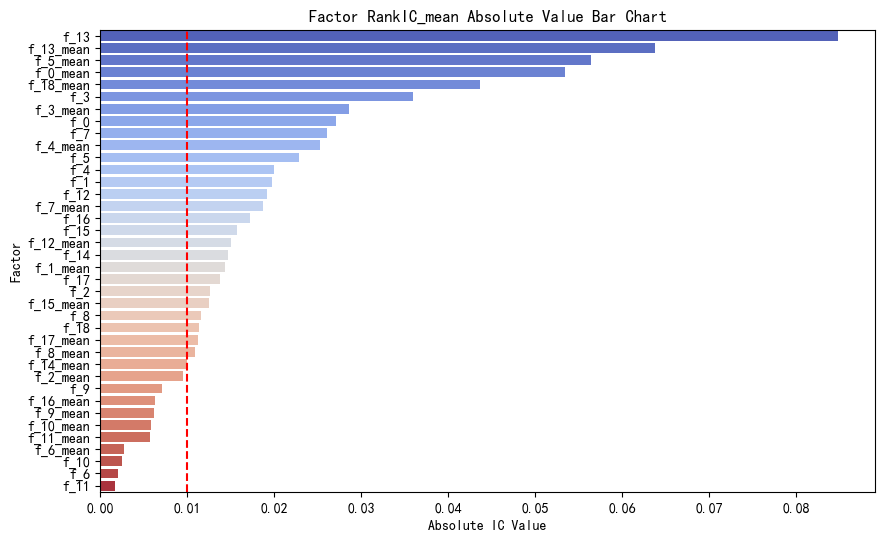

In [32]:
#绘制各个因子的IC均值
ic_df = pd.DataFrame(iclib)
ic_df["IC_abs"] = ic_df["RankICMean"].abs()
ic_df = ic_df.sort_values(by="IC_abs", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="IC_abs", y="factor", data=ic_df, palette="coolwarm")
plt.axvline(0.01,linestyle='--',color='red')
plt.xlabel("Absolute IC Value")
plt.ylabel("Factor")
plt.title("Factor RankIC_mean Absolute Value Bar Chart")
plt.show()

In [ ]:
#去除IC均值（绝对值）在0.01以下的因子
omit_factors = list(ic_df[ic_df['IC_abs']<=0.01].factor)
train_data.drop(omit_factors,axis=1,inplace=True)
test_data.drop(omit_factors,axis=1,inplace=True)

数据预处理

In [8]:
class DataProcessor:
    def __init__(self, train_valid_data, test_data, params, code_col='code', date_col='date', factor_cols=None, label_cols=None):
        self.train_valid_data = train_valid_data.copy().set_index([date_col, code_col])
        self.test_data = test_data.set_index([date_col, code_col])
        self.params = params
        self.code_col = code_col
        self.date_col = date_col
        self.factor_cols = factor_cols or [fs for fs in list(self.train_valid_data.columns) if fs not in ['y']]
        self.label_cols = label_cols or ['y']
        self.Processor()
    
    def Processor(self):
        for step in self.params:
            method_name = step.get('class')
            data_group = step.get('data_group', 'all')
            fields_group = step.get('fields_group', 'all')
            method_params = step.get('params')

            if not hasattr(self, method_name):
                raise ValueError(f'Data processing method {method_name} does not exist.')

            func = getattr(self, method_name)

            if data_group in ['all', 'train_valid_data']:
                self.train_valid_data = self._apply_function(self.train_valid_data, func, fields_group, method_params)
            if data_group in ['all', 'test_data']:
                self.test_data = self._apply_function(self.test_data, func, fields_group, method_params)
    
    def _apply_function(self, data, func, fields_group, params):
        cols = {
            'all': data.columns,
            'factor': self.factor_cols,
            'label': self.label_cols
        }.get(fields_group, None)

        if cols is None:
            raise ValueError(f'未知 fields_group {fields_group}')
        
        data.loc[:, cols] = func(data[cols], params)
        return data
    
    def ToNum(self,df,params=None):
        df = df.copy()
        return df.apply(pd.to_numeric, errors='coerce')
    
    def CSMidClipOutlier(self, df, params=5):
        df = df.copy()
        params = params or 5

        def ps_CSMCO(series):
            #series = pd.to_numeric(series, errors='coerce')
            D_M = np.median(series)
            D_M1 = np.median(np.abs(series - D_M))
            return series.clip(lower=D_M - params * D_M1, upper=D_M + params * D_M1)

        return pd.concat([group.apply(ps_CSMCO,axis=0) for _,group in df.groupby(self.date_col)])
        #return df.groupby(self.date_col).apply(lambda group: group.apply(ps_CSMCO, axis=0))

    def CSMinMaxNorm(self,df, params=None):
        return pd.concat([(group - group.min()) / (group.max() - group.min()) for _,group in df.groupby(self.date_col)])
        #df.groupby('date').apply(lambda group: (group - group.min()) / (group.max() - group.min()))

    def CSZScoreNorm(self,df, params=None):
        return pd.concat([(group - group.mean()) / group.std() for _,group in df.groupby(self.date_col)])
        #df.groupby('date').apply(lambda group: (group - group.mean()) / group.std())

    def CSRankNorm(self,df, params=None):
        return pd.concat([(group.rank(method='average')  - group.rank(method='average').mean()) / group.rank(method='average').std() for _,group in df.groupby(self.date_col)])
        #df.groupby('date').apply(lambda group: (group.rank(method='average')  - group.rank(method='average').mean()) / group.rank(method='average').std())

    def DropNa(self, df, params=None):
        return df.dropna()

    def CSZFillNa(self, df, params=None):
        return pd.concat([group.fillna(group.mean()) for _,group in df.groupby(self.date_col)])
        #df.groupby('date').apply(lambda group: group.fillna(group.mean()))


In [ ]:
#数据预处理：去极值、标准化
from DataProcessor import DataProcessor 
params = [
    {"class":'ToNum'},
    {"class":'CSZFillNa'},
    {"class":'CSMidClipOutlier','field_group':'factor','params':5},
    {"class":'CSZScoreNorm',"fields_group":'factor'},
    {'class':'CSRankNorm','data_group':'train_valid_data','field_group':'label'}
]
DP = DataProcessor(train_valid_data=train_data,test_data=test_data,params=params)
possessed_train_data = DP.train_valid_data
possessed_train_data.to_pickle('data/possessed_train_data6_2.pkl')
possessed_test_data = DP.test_data
possessed_test_data.to_pickle('data/possessed_test_data6_2.pkl')

特征工程

KMO和巴特勒球形度检验 BartlettResult(statistic=5.077029244510833, pvalue=0.9847115173601334)
方差解释表
            特征根     方差百分比        累积
主成分1   3.389326  0.226037  0.226037
主成分2   2.339627  0.156032  0.382069
主成分3   2.070718  0.138098  0.520168
主成分4   1.729618  0.115350  0.635517
主成分5   1.277842  0.085221  0.720738
主成分6   1.113794  0.074280  0.795018
主成分7   0.852242  0.056837  0.851855
主成分8   0.548438  0.036576  0.888431
主成分9   0.440751  0.029394  0.917825
主成分10  0.353347  0.023565  0.941390
主成分11  0.258296  0.017226  0.958616
主成分12  0.239980  0.016004  0.974620
主成分13  0.165748  0.011054  0.985674
主成分14  0.155858  0.010394  0.996068
主成分15  0.058952  0.003932  1.000000


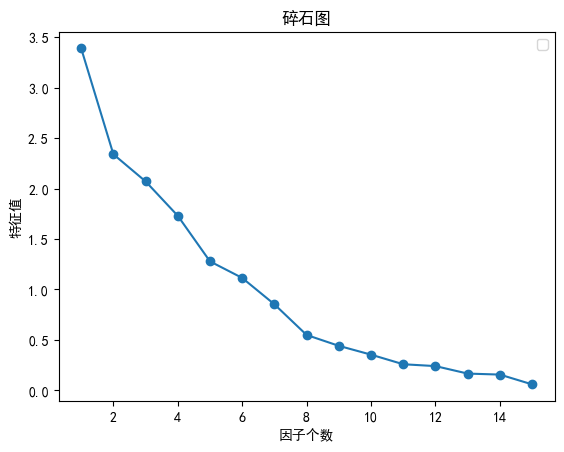

请输入选取的主成分数目：
成分矩阵表
             x1        x2        x3        x4        x5        x6        x7  \
主成分1   0.464245 -0.021985  0.029264  0.034607  0.436212  0.494712  0.007469   
主成分2   0.044953 -0.004501  0.459043  0.142159 -0.112857 -0.030992  0.297407   
主成分3   0.116230  0.593136 -0.111074 -0.436583 -0.083542  0.040431  0.388087   
主成分4   0.095997 -0.068725 -0.166127  0.289941 -0.123489 -0.000404  0.389375   
主成分5   0.127756  0.328286 -0.090240  0.361570 -0.152095  0.029224 -0.135388   
主成分6  -0.015351 -0.069981 -0.479411 -0.013367  0.012704 -0.007405  0.028361   
主成分7  -0.116334  0.141156 -0.005723  0.203105  0.079372 -0.256867  0.048667   
主成分8  -0.403087  0.092290 -0.088528  0.470493  0.500633  0.051436 -0.103449   
主成分9  -0.164960  0.247559  0.375092  0.146051  0.209745  0.019733  0.416788   
主成分10 -0.116856  0.008111 -0.308064  0.097971  0.149575 -0.005859  0.484387   
主成分11 -0.337326 -0.037563 -0.083035 -0.510139  0.477047 -0.097960  0.003012   
主成分12  0.067947  0.084944 -0.5096

'主成分分析已完成'

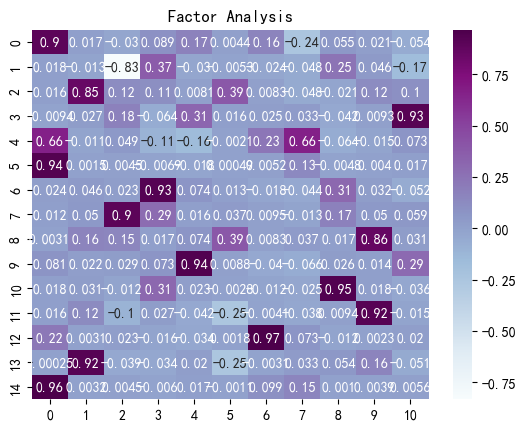

In [ ]:
from PCA import PCA_analysis
pca = PCA_analysis(possessed_train_data.iloc[:,:-1])
pca.run()
k=20 #选取前20个主成分

调参

In [ ]:
class BaseTuneParams:
    def __init__(self,X,y):
        self.X = X
        self.y = y
    def GridSearchTune(self,model,params_dicts,cv=5):
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params_dicts,
            scoring=make_scorer(r2_score),
            cv=cv,
            n_jobs=-1,
            verbose=2
        )
        grid_search.fit(self.X, self.y)
        return grid_search
    @staticmethod
    def BysOpt(func,params_dicts,init_points=1,n_iter=20):
        bayes = BayesianOptimization(
            func,
            params_dicts
        )
        bayes.maximize(init_points=init_points,n_iter=n_iter)    
        return bayes

In [ ]:
#LightGBM: 设置交叉验证调参及参数空间
from lightgbm import LGBMRegressor
class LGBMCVTuneParams(BaseTuneParams):
    def __init__(self, X, y,cv=5,params=None,params_dict=None):
        super().__init__(X, y)
        self.cv = cv
        if params is None:
            params = {
                'boosting_type': 'gbdt',
                'max_depth': 7,
                'num_leaves': 31,
                'learning_rate': 0.1,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1
            }
        self.params = params
        if params_dict is None:
            params_dict = {
                'max_depth':range(7,11),
                'num_leaves':range(10,90,10),
                'learning_rate': (0.01, 0.2)
            }
        self.params_dict = params_dict 
        self.tp = BaseTuneParams.BysOpt(self.lightgbm_cv,self.params_dict)
        self.best_params = self.tp.max.get('params')

    def lightgbm_cv(self,max_depth, num_leaves,learning_rate):
        self.params.update({'max_depth':int(max_depth),'num_leaves':int(num_leaves),'learning_rate':learning_rate})
        model = LGBMRegressor(**self.params)
        scores = cross_validate(
            model, self.X, self.y, cv=self.cv, scoring=make_scorer(r2_score), return_train_score=True
        )
        return np.mean(scores['test_score'])

In [ ]:
#CatBoost:设置交叉验证调参及参数空间
from ParamsTuning import BaseTuneParams
class CatBoostCVTuneParams(BaseTuneParams):
    def __init__(self, X, y,cv = 5,params=None,params_dict=None):
        super().__init__(X, y)
        self.cv = cv
        if params is None:
            params = {
                'loss_function': 'RMSE',
                'eval_metric': 'RMSE',
                'iterations': 50,
                'learning_rate': 0.1,
                'depth': 4,
                'subsample': 0.6,
                'random_seed': 123,
                'l2_leaf_reg': 5,
                'bootstrap_type': 'Bernoulli',
                'sampling_frequency': 'PerTree',
                'grow_policy': 'SymmetricTree',
                'min_data_in_leaf': 500,
                'one_hot_max_size': 4,
                'nan_mode': 'Max',
                'boosting_type': 'Ordered',
                'max_ctr_complexity': 2,
                'logging_level': 'Silent',
                'border_count': 254,
                'feature_border_type': 'GreedyLogSum',
                'task_type':'GPU',
                'devices':'0',
                "early_stopping_rounds":50,
            }
        self.params = params
        if params_dict is None:
            params_dict = {
                'iterations': (50, 300),
                'learning_rate': (0.01, 0.2),
                'depth': (3, 10),
                'subsample': (0.6, 1.0),
            }
        self.params_dict = params_dict
        
        self.tp = BaseTuneParams.BysOpt(self.catboost_cv,self.params_dict)
        self.best_params = self.tp.max.get('params')

    def catboost_cv(self,iterations, learning_rate, depth, subsample):
        self.params.update({'iterations':int(iterations),'depth':int(depth),'learning_rate':learning_rate,'subsample':subsample})
        model = CatBoostRegressor(**self.params)
        scores = cross_validate(
            model, self.X, self.y, cv=self.cv, scoring=make_scorer(r2_score), return_train_score=True
        )
        return np.mean(scores['test_score'])

In [ ]:
#XgBoost:设置交叉验证调参及参数空间
from xgboost import XGBRegressor
class XGBCVTuneParams(BaseTuneParams):
    def __init__(self, X, y, cv=5, params=None, params_dict=None):
        super().__init__(X, y)
        self.cv = cv

        if params is None:
            params = {
                'objective': 'reg:squarederror',
                'tree_method': 'gpu_hist',  #使用GPU训练
                'predictor': 'gpu_predictor',
                'verbosity': 0
            }
        self.params = params

        if params_dict is None:
            params_dict = {
                'learning_rate': (0.01, 0.3),
                'n_estimators': (300, 1000),
                'max_depth': (3, 6),
                'subsample': (0.6, 0.8),
                'gamma': (0, 0.3)
            }

        self.params_dict = params_dict
        self.tp = BaseTuneParams.BysOpt(self.xgboost_cv, self.params_dict)
        self.best_params = self.tp.max.get('params')

    def xgboost_cv(self, **kwargs):
        for k, v in kwargs.items():
            self.params[k] = int(v) if k in ['max_depth', 'n_estimators'] else v

        model = XGBRegressor(**self.params)
        scores = cross_validate(
            model, self.X, self.y,
            cv=self.cv, scoring=make_scorer(r2_score),
            return_train_score=True
        )
        return np.mean(scores['test_score'])


In [ ]:
#借助kaggle在线GPU算力调参
if __name__ == "__main__":
    X = pca.data_dr.values
    y = possessed_train_data['y'].values
    catcv_tuning = CatBoostCVTuneParams(X,y)
    best_params_cat = catcv_tuning.best_params
    lgbmcv_tuning = LGBMCVTuneParams(X,y)
    best_params_lgbm = lgbmcv_tuning.best_params
    xgbcv_tuning = XGBCVTuneParams(X,y)
    best_params_xgv = xgbcv_tuning.best_params

模型训练与预测

In [ ]:
#XgBoost模型训练与预测
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from Model import Model
class XGBoostModel(Model):
    def __init__(self, batch_size=None, **kwargs):
        self.batch_size = batch_size
        self._params = {
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'learning_rate': 0.1,
            'n_estimators': 500,
            'max_depth': 4,
            'subsample': 0.7,
            'gamma': 0.1,
            'random_state': 42
        }
        self._params.update(kwargs)
        self.model = None

    def fit(self, dataset):
        X = dataset.get('X')
        y = dataset.get('y')
        if self.batch_size is not None:
            self.batch_fit(X, y)
            return
        self.model = XGBRegressor(**self._params)
        self.model.fit(X, y)
        return

    def batch_fit(self, X, y, train_test_split=0.2):
        '''
        X and y have multi index
        level 0: date
        level 1: code
        '''
        data = pd.concat([X, y], axis=1)
        unique_dates = sorted(data.index.get_level_values(0).unique())
        models = []
        print('Begin Batch Training:')
        for i in tqdm(range(0, len(unique_dates), self.batch_size)):
            batch_dates = unique_dates[i:i + self.batch_size]
            batch_data = data.loc[data.index.get_level_values(0).isin(batch_dates)]
            if batch_data.empty:
                print(f'No data for batch {i // self.batch_size}.')
                continue
            train_mask = (np.random.rand(len(batch_data)) > train_test_split)
            val_mask = ~train_mask
            train_X = batch_data.iloc[train_mask, :-1]
            val_X = batch_data.iloc[val_mask, :-1]
            train_y = batch_data.iloc[train_mask, -1]
            val_y = batch_data.iloc[val_mask, -1]

            model = XGBRegressor(**self._params)
            model.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=10, verbose=False)
            models.append((f'model_{i}', model))
        print('Finish Batch Training.')
        self.model = VotingRegressor(estimators=models)
        return

    def predict(self, dataset):
        if self.model is None:
            raise ValueError("model is not fitted yet!")
        X_test = dataset.get('X_test')
        self.y_pred = pd.DataFrame(self.model.predict(X_test.values), index=X_test.index)
        return self.y_pred
if __name__ == "__main__":
    best_params = {
        'gamma':0.1956,
        'learning_rate':0.03936,
        'max_depth':5,
        'n_estimators':872,
        'sub_sample':0.7238,
    }

    k = 20
    X_test = possessed_test_data @ pca.components.iloc[0:k,:].T.values
    X_test.columns = pca.data_dr.columns #准备处理后测试集数据
    dataset = {
        'X':pca.data_dr,
        'y':possessed_train_data['y'],
        'X_test':X_test
        } #准备数据

    model = XGBoostModel(batch_size=100,**best_params)
    model.fit(dataset) #模型训练
    model.model.fit(dataset['X'],dataset['y'])

    y_pred_xgb = model.model.predict(X_test)
    y_pred_xgb = pd.DataFrame(y_pred_xgb,index = X_test.index)
    y_pred_xgb.columns = ['y_pred_xgb']
    y_pred_xgb.reset_index(inplace=True)
    y_pred_xgb['id'] = y_pred_xgb.index

In [ ]:
#LightGBM模型训练与预测
from sklearn.ensemble import VotingRegressor
from Model import Model
class LightGBMModel(Model):
    def __init__(self,batch_size=None,**kwargs):
        self.batch_size = batch_size
        self._params = {
                'boosting_type': 'gbdt',
                'max_depth': 7,
                'num_leaves': 31,
                'learning_rate': 0.1,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': -1,
                'device': 'gpu',            
                'gpu_platform_id': 0,        
                'gpu_device_id': 0,
            }
        self._params.update(kwargs)
        self.model = None
    def fit(self,dataset):
        X = dataset.get('X')
        y = dataset.get('y')
        if self.batch_size is not None:
            self.batch_fit(X,y)
            return
        self.model = LGBMRegressor(**self._params)
        self.model.fit(X,y)
        # current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        # model_save_path = os.path.join('models',f'CatBoost_{current}.cb')
        # self.model.save_model(model_save_path)
        return
    def batch_fit(self,X,y,train_test_split = 0.2):
        '''
        X and y have multi index
        level 0: date
        level 1: code
        '''
        data = pd.concat([X,y],axis=1)
        unique_dates = sorted(data.index.get_level_values(0).unique())
        models = []
        print('Begin Batch Training:')
        for i in tqdm(range(0,len(unique_dates),self.batch_size)):
            batch_dates = unique_dates[i:i+self.batch_size]
            batch_data = data.loc[data.index.get_level_values(0).isin(batch_dates)]
            if batch_data.empty:
                print(f'No data for batch {i//self.batch_size}.')
            train_mask = (np.random.rand(len(batch_data)) > train_test_split)
            val_mask = ~train_mask
            train_X = batch_data.iloc[train_mask,:-1]
            val_X = batch_data.iloc[val_mask,:-1]
            train_y = batch_data.iloc[train_mask,-1]
            val_y = batch_data.iloc[val_mask,-1]
            train_pool = Pool(train_X,label=train_y)
            val_pool = Pool(val_X,label=val_y)
            if models:
                train_pool.set_baseline(models[-1].predict(train_pool))
                val_pool.set_baseline(models[-1].predict(val_pool))
            model = LGBMRegressor(**self._params)
            model.fit(train_pool,eval_set=val_pool,early_stopping_rounds=10)
            models.append(model)
        print('Finish Batch Training.')
        self.model = VotingRegressor(estimators=models)
        # current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        # model_save_path = os.path.join('models',f'CatBoost_batch_{current}.cb')
        # self.model.save_model(model_save_path)
        return
    def predict(self,dataset):
        if self.model is None:
            raise ValueError("model is not fitted yet!")
        X_test = dataset.get('X_test')
        self.y_pred = pd.DataFrame(self.model.predict(X_test.values),index = X_test.index)
        return
if __name__ == "__main__":
    # k = 20
    # X_test = possessed_test_data @ pca.components.iloc[0:k,:].T.values
    # X_test.columns = pca.data_dr.columns #准备处理后测试集数据
    # dataset = {
    #     'X':pca.data_dr,
    #     'y':possessed_train_data['y'],
    #     'X_test':X_test
    #     } #准备数据

    best_params = {
        'learning_rate': 0.09161,
        'max_depth': 10,
        'num_leaves':85
        } #准备参数
    
    model = LightGBMModel(batch_size=100,**best_params)
    model.fit(dataset) #模型训练
    model.model.fit(dataset['X'],dataset['y'])

    y_pred_lgbm = model.model.predict(X_test)
    y_pred_lgbm = pd.DataFrame(y_pred_lgbm,index = X_test.index)
    y_pred_lgbm.columns = ['y_pred_lgbm']
    y_pred_lgbm.reset_index(inplace=True)
    y_pred_lgbm['id'] = y_pred_lgbm.index


In [ ]:
#CatBoost模型训练与预测
from Model import Model
class CatBoostModel(Model):
    def __init__(self,batch_size=None,**kwargs):
        self.batch_size = batch_size
        self._params = {
                'loss_function': 'RMSE',
                'eval_metric': 'RMSE',
                'iterations': 50,
                'learning_rate': 0.1,
                'depth': 4,
                'subsample': 0.6,
                'random_seed': 123,
                'l2_leaf_reg': 5,
                'bootstrap_type': 'Bernoulli',
                'sampling_frequency': 'PerTree',
                'grow_policy': 'SymmetricTree',
                'min_data_in_leaf': 500,
                'one_hot_max_size': 4,
                'nan_mode': 'Max',
                'boosting_type': 'Ordered',
                'max_ctr_complexity': 2,
                'logging_level': 'Silent',
                'border_count': 254,
                'feature_border_type': 'GreedyLogSum',
                # 'task_type':'GPU',
                # 'devices':'0',
                "early_stopping_rounds":50,
            }
        self._params.update(kwargs)
        self.model = None
    def fit(self,dataset):
        X = dataset.get('X')
        y = dataset.get('y')
        if self.batch_size is not None:
            self.batch_fit(X,y)
            return
        self.model = CatBoostRegressor(**self._params)
        self.model.fit(X,y)
        current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        model_save_path = os.path.join('models',f'CatBoost_{current}.cb')
        self.model.save_model(model_save_path)
        return
    def batch_fit(self,X,y,train_test_split = 0.2):
        '''
        X and y have multi index
        level 0: date
        level 1: code
        '''
        data = pd.concat([X,y],axis=1)
        unique_dates = sorted(data.index.get_level_values(0).unique())
        models = []
        print('Begin Batch Training:')
        for i in tqdm(range(0,len(unique_dates),self.batch_size)):
            batch_dates = unique_dates[i:i+self.batch_size]
            batch_data = data.loc[data.index.get_level_values(0).isin(batch_dates)]
            if batch_data.empty:
                print(f'No data for batch {i//self.batch_size}.')
            train_mask = (np.random.rand(len(batch_data)) > train_test_split)
            val_mask = ~train_mask
            train_X = batch_data.iloc[train_mask,:-1]
            val_X = batch_data.iloc[val_mask,:-1]
            train_y = batch_data.iloc[train_mask,-1]
            val_y = batch_data.iloc[val_mask,-1]
            train_pool = Pool(train_X,label=train_y)
            val_pool = Pool(val_X,label=val_y)
            if models:
                train_pool.set_baseline(models[-1].predict(train_pool))
                val_pool.set_baseline(models[-1].predict(val_pool))
            model = CatBoostRegressor(**self._params)
            model.fit(train_pool,eval_set=val_pool,early_stopping_rounds=10)
            models.append(model)
        print('Finish Batch Training.')
        self.model = sum_models(models)
        current = datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        model_save_path = os.path.join('models',f'CatBoost_batch_{current}.cb')
        self.model.save_model(model_save_path)
        return
    def predict(self,dataset):
        if self.model is None:
            raise ValueError("model is not fitted yet!")
        X_test = dataset.get('X_test')
        self.y_pred = pd.DataFrame(self.model.predict(X_test.values),index = X_test.index)
        return
if __name__ == "__main__":
    best_params = {'depth': 10,
        'iterations': 228,
        'learning_rate': 0.05823619953836616,
        'subsample': 0.70
        } #准备参数
    model = CatBoostModel(batch_size=100,**best_params)
    model.fit(dataset) #模型训练
    model.predict(dataset) #模型预测

    y_pred_cat = model.y_pred
    y_pred_cat.columns = ['y_pred_cat']
    y_pred_cat.reset_index(inplace=True)
    y_pred_cat.index.name = 'id'

模型集成

In [ ]:
'''
ensemble方法为多个模型取简单平均
最后选择了LGBM和XgBoost模型效果较好
'''
y_pred_2GBDT = (y_pred_lgbm+y_pred_xgb)/2